In [1]:
!pip install scanpy

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 141.9/141.9 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 8.0 MB/s eta 0:00:00
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8023 sha256=b870c3bc20728b71a96fb06577c3ea16ac77cb61f3d061ece8b171110bdd8c69
  Stored in directory: /root/.cache/pip/wheels/6a/aa/b9/eb5d4031476ec10802795b97ccf937b9bd998d68a9b268765a
Successfully built session-info


In [2]:
import scanpy as sc
import pandas as pd
import numpy as np

Performing quality control...
Filtering cells...
Filtered data shape: (5845, 34546)
Normalizing data...


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:207: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Selecting highly variable genes and scaling data...


/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_scale.py:318: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Running PCA and constructing neighbors graph...
Computing UMAP embedding...


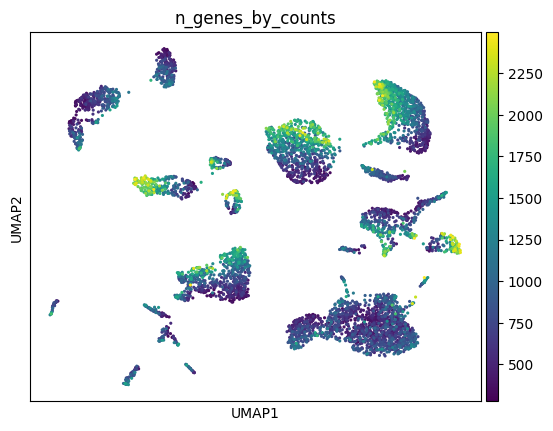

Clustering cells using Louvain algorithm...


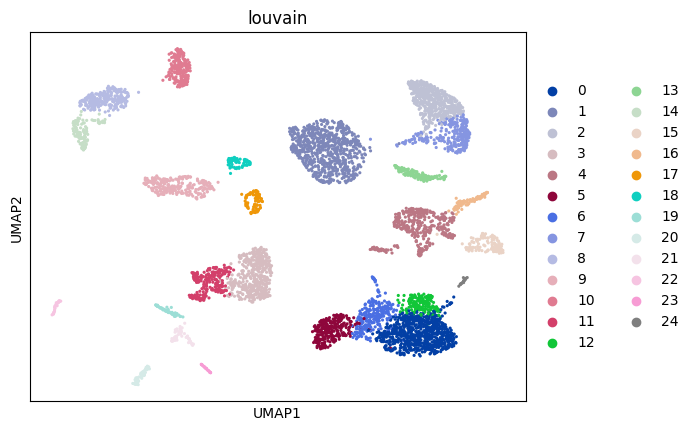

Identifying marker genes for each cluster...


/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: 

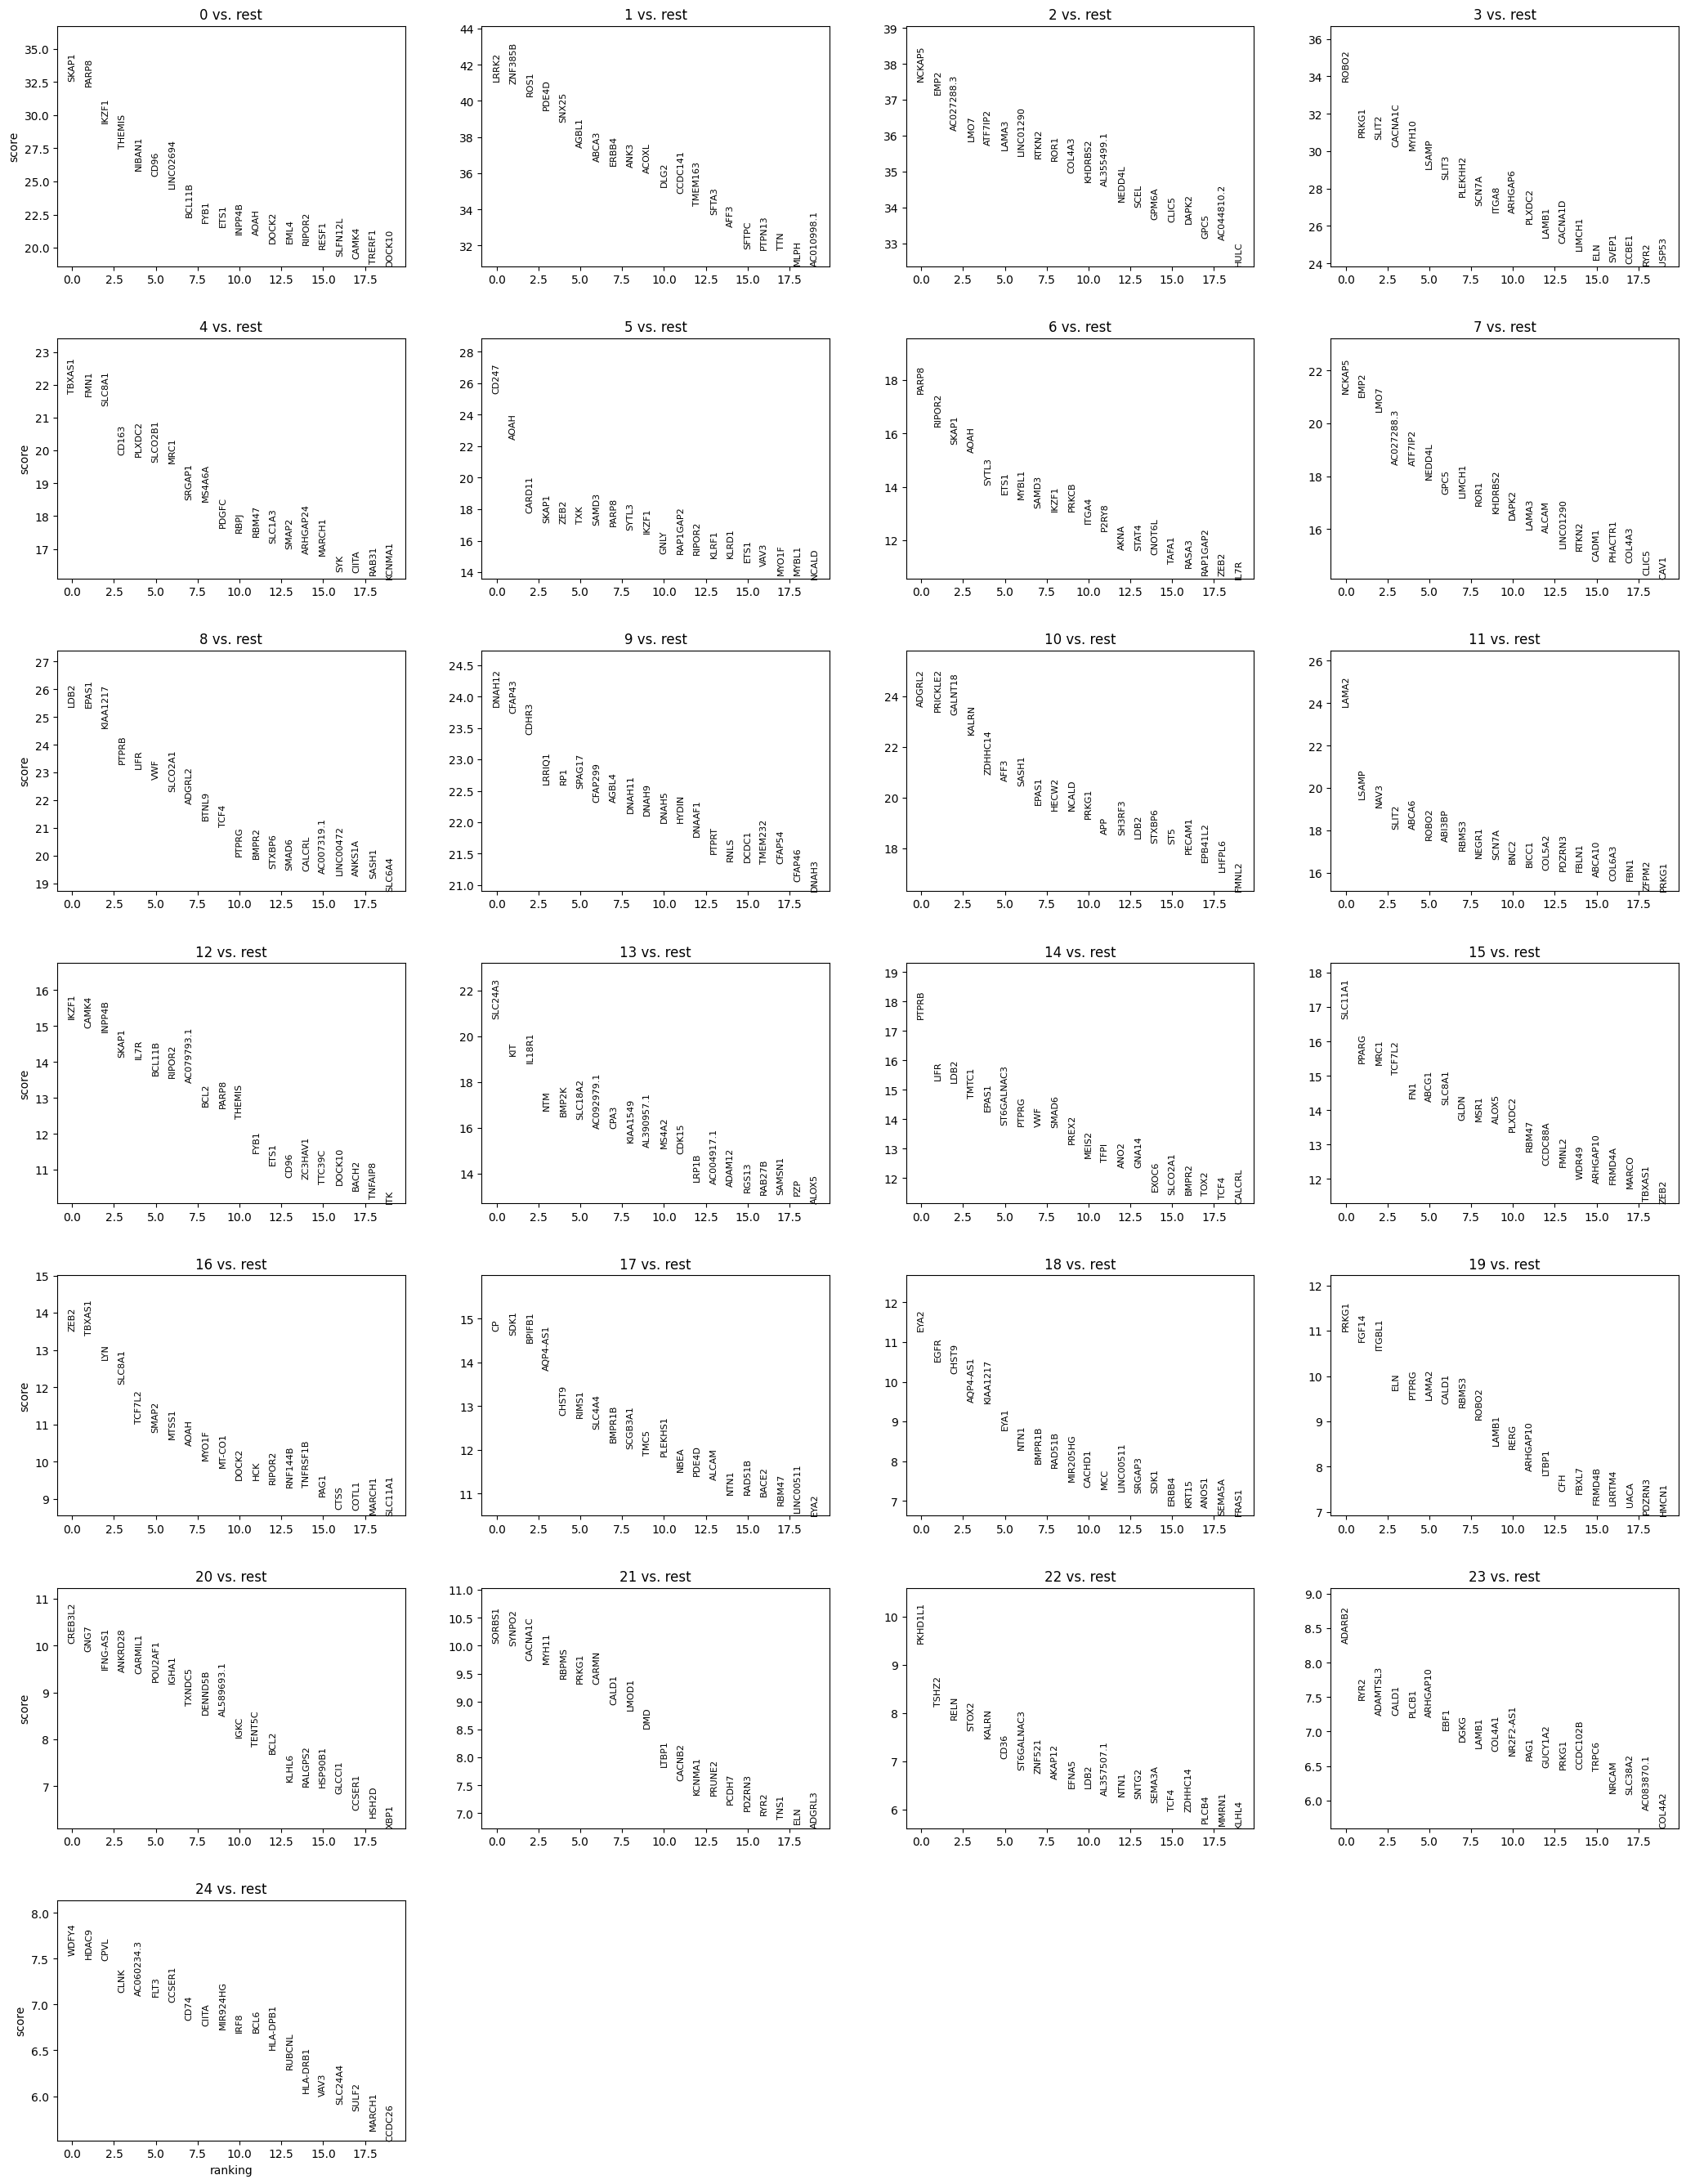

Extracting differential expression results...
Top marker genes with p-values and adjusted p-values:
  Cluster       Gene        p_value  adjusted_p_value  log_fold_change
0       0      SKAP1  1.733119e-232     9.785191e-229              NaN
1       0      PARP8  3.938209e-227     1.111756e-223              NaN
2       0      IKZF1  3.734467e-190     7.028268e-187              NaN
3       0     THEMIS  8.766248e-167     1.237356e-163              NaN
4       0     NIBAN1  2.304976e-147     2.602779e-144              NaN
5       0       CD96  7.614459e-143     7.165206e-140              NaN
6       0  LINC02694  3.220363e-132     2.597452e-129              NaN
7       0     BCL11B  2.249289e-110     1.587436e-107              NaN
8       0       FYB1  4.006276e-106     2.513270e-103              NaN
9       0       ETS1  2.126636e-103     1.200698e-100              NaN


In [122]:

adata = sc.read_csv('/content/drive/MyDrive/GSE171524_RAW/GSM5226574_C51ctr_raw_counts.csv.gz').T

# Quality Control (QC)
print("Performing quality control...")
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

# Filter cells based on mitochondrial content and gene counts
print("Filtering cells...")
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]
print(f"Filtered data shape: {adata.shape}")

# Normalize the data
print("Normalizing data...")
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Highly variable genes and scaling
print("Selecting highly variable genes and scaling data...")
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata = adata[:, adata.var.highly_variable]
sc.pp.scale(adata, max_value=10)

# PCA and neighbors
print("Running PCA and constructing neighbors graph...")
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# UMAP embedding
print("Computing UMAP embedding...")
sc.tl.umap(adata)
sc.pl.umap(adata, color="n_genes_by_counts")

# Clustering using Louvain
print("Clustering cells using Louvain algorithm...")
sc.tl.louvain(adata, resolution=1.0)  # Adjust resolution for cluster granularity
sc.pl.umap(adata, color="louvain")

# Finding cluster-specific markers
print("Identifying marker genes for each cluster...")
sc.tl.rank_genes_groups(adata, "louvain", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=20, sharey=False)
# Extract results into a DataFrame
print("Extracting differential expression results...")
result = adata.uns['rank_genes_groups']
marker_genes = pd.DataFrame()

# Combine marker genes, p-values, and log fold changes for all clusters
for group in result['names'].dtype.names:  # Loop through clusters
    genes = result['names'][group]  # Marker genes
    pvals = result['pvals'][group]  # P-values
    pvals_adj = result['pvals_adj'][group]  # Adjusted p-values
    logfc = result['logfoldchanges'][group]  # Log fold changes

    temp_df = pd.DataFrame({
        'Cluster': group,
        'Gene': genes,
        'p_value': pvals,
        'adjusted_p_value': pvals_adj,
        'log_fold_change': logfc
    })
    marker_genes = pd.concat([marker_genes, temp_df], ignore_index=True)

# Display the top 10 DEGs for each cluster
print("Top marker genes with p-values and adjusted p-values:")
print(marker_genes.head(10))



           0        1           2        3        4       5       6  \
0      SKAP1    LRRK2      NCKAP5    ROBO2   TBXAS1   CD247   PARP8   
1      PARP8  ZNF385B        EMP2    PRKG1     FMN1    AOAH  RIPOR2   
2      IKZF1     ROS1  AC027288.3    SLIT2   SLC8A1  CARD11   SKAP1   
3     THEMIS    PDE4D        LMO7  CACNA1C    CD163   SKAP1    AOAH   
4     NIBAN1    SNX25     ATF7IP2    MYH10   PLXDC2    ZEB2   SYTL3   
5       CD96    AGBL1       LAMA3    LSAMP  SLCO2B1     TXK    ETS1   
6  LINC02694    ABCA3   LINC01290    SLIT3     MRC1   SAMD3   MYBL1   
7     BCL11B    ERBB4       RTKN2  PLEKHH2   SRGAP1   PARP8   SAMD3   
8       FYB1     ANK3        ROR1    SCN7A   MS4A6A   SYTL3   IKZF1   
9       ETS1    ACOXL      COL4A3    ITGA8    PDGFC   IKZF1   PRKCB   

            7         8        9  ...       15      16        17        18  \
0      NCKAP5      LDB2   DNAH12  ...  SLC11A1    ZEB2        CP      EYA2   
1        EMP2     EPAS1   CFAP43  ...    PPARG  TBXAS1      SD

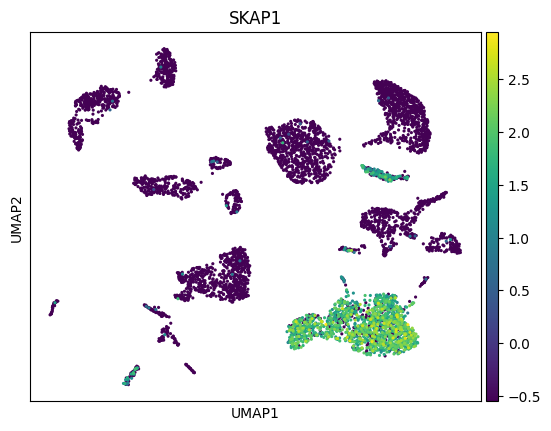

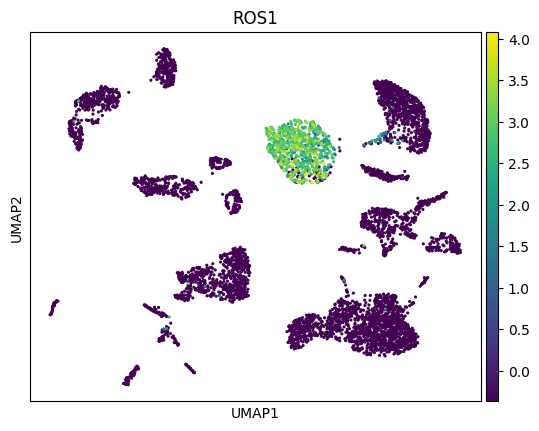

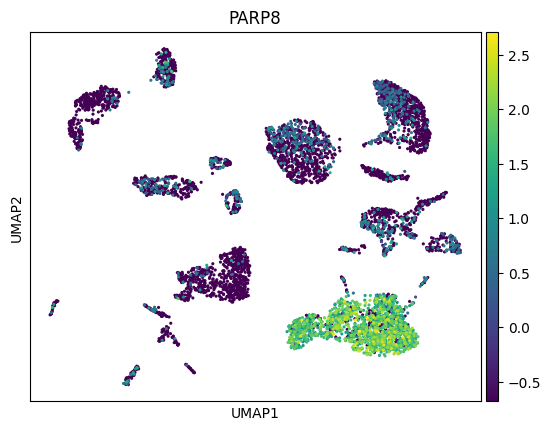

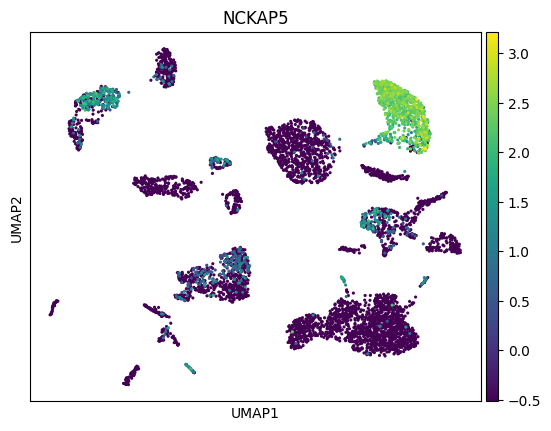

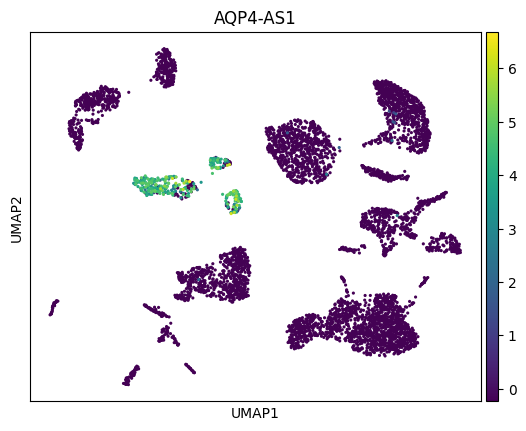

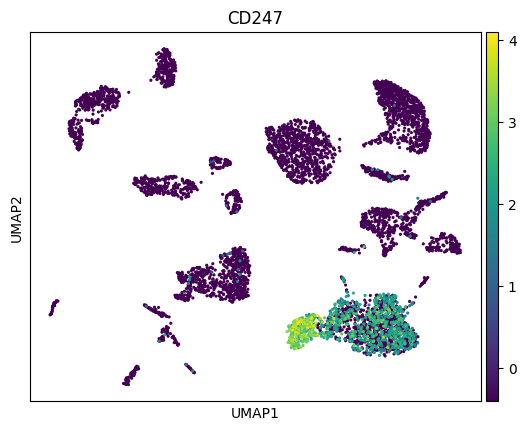

Generating heatmap for top marker genes...


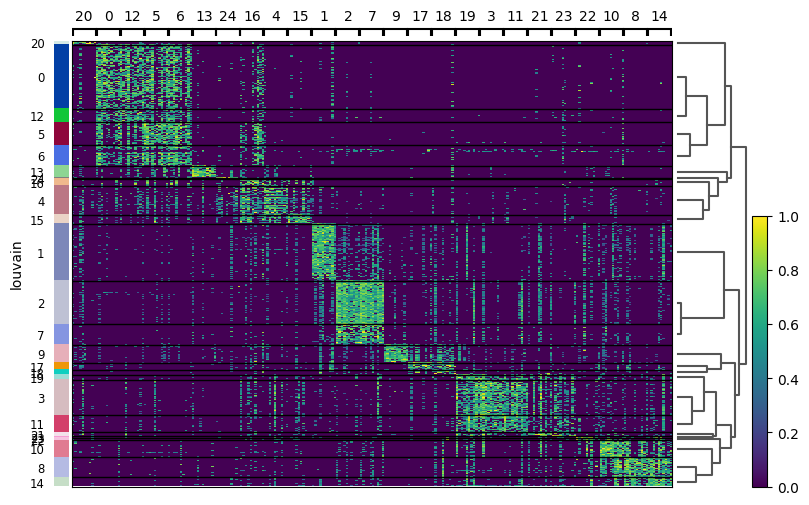

Performing differential expression analysis between clusters...


/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, "logfoldchanges"] = np.log2(
/usr/local/lib/python3.10/dist-packages/scanpy/tools/_rank_genes_groups.py:455: 

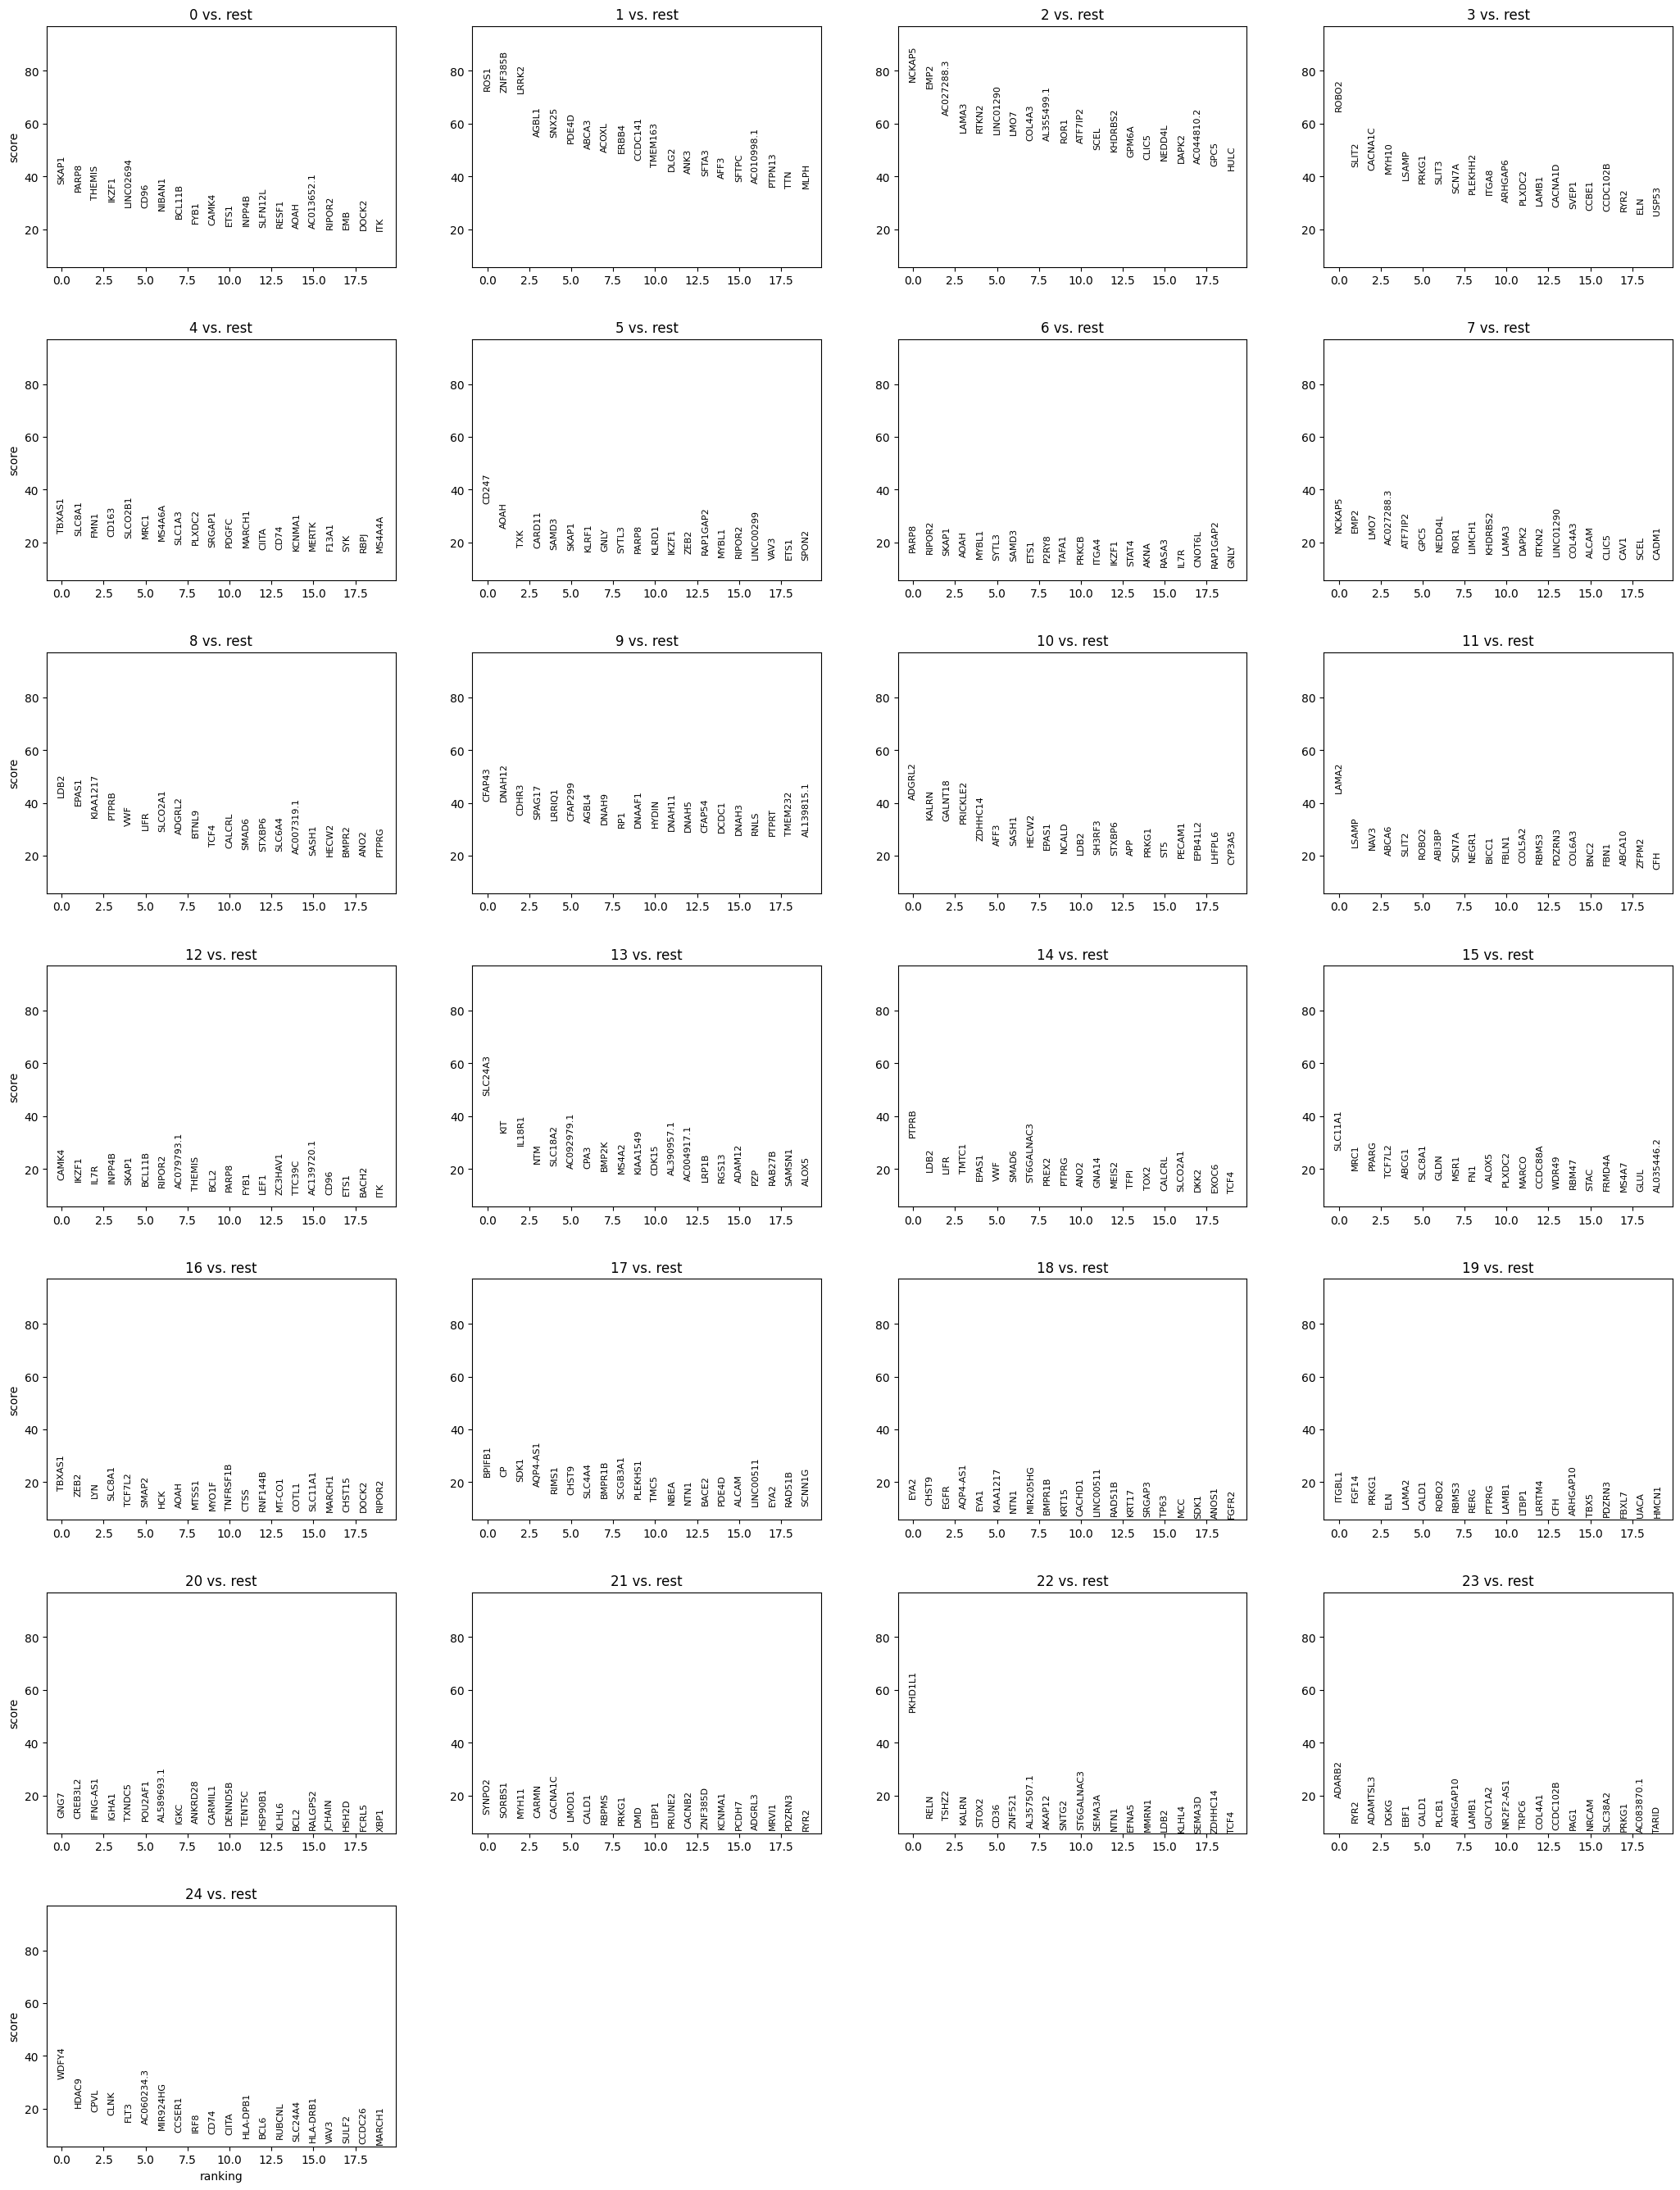

Subset and analyze specific clusters...
Subset data shape: (750, 5646)


In [123]:
# Store marker genes into a dataframe
import pandas as pd
markers = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(10)
print(markers)



# Advanced Visualization
print("Generating advanced visualizations...")
# 1. Gene expression on UMAP
marker_genes = ["SKAP1", "ROS1","PARP8","NCKAP5","AQP4-AS1","CD247"]  # Replace with actual marker genes of interest
for gene in marker_genes:
    sc.pl.umap(adata, color=gene)

# 2. Cluster-specific heatmap
print("Generating heatmap for top marker genes...")
sc.pl.rank_genes_groups_heatmap(
    adata, n_genes=10, groupby="louvain", standard_scale="var", cmap="viridis"
)

# Differential Expression Analysis
print("Performing differential expression analysis between clusters...")
sc.tl.rank_genes_groups(adata, groupby="louvain", method="t-test_overestim_var")
sc.pl.rank_genes_groups(adata, n_genes=20)

# Subsetting a specific cluster for further analysis
print("Subset and analyze specific clusters...")
cluster_of_interest = "1"  # Replace with your cluster of interest
adata_subset = adata[adata.obs["louvain"] == cluster_of_interest]
print(f"Subset data shape: {adata_subset.shape}")

# Save subset data
adata_subset.write("subset_cluster.h5ad")
